In [1]:
# Import packages
from sklearn.model_selection import train_test_split
import random
import csv
import numpy as np
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import networkx as nx 
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt 

with open("socfb-Carnegie49.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

In [2]:
#generate the data set
dataset=[element[0].split(" ") for element in training_set]
node_list = []
for i, j in dataset:
    if i not in node_list:
        node_list.append(i)
    if j not in node_list:
        node_list.append(j)
node_list = [int(i) for i in node_list]
node_list.sort()

In [3]:
#defining the graph
g = nx.Graph() 
for el in node_list:
    g.add_node(el)

edges = [(element[0],element[1]) for element in dataset]
for i,j in edges:
    g.add_edge(int(i), int(j))

In [4]:
edges=dict()
for edge in dataset:
    edges[(int(edge[0]), int(edge[1]))] = 1

DESCRIPTIVE STATS

In [5]:
# No of Unique persons 
print("The number of unique persons in the network is",len(g.nodes()))

The number of unique persons in the network is 6637


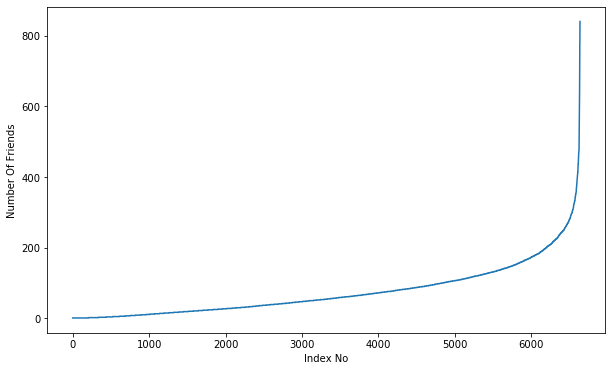

In [6]:
degree_dist = list(dict(g.degree()).values())
degree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(degree_dist)
plt.xlabel('Index No')
plt.ylabel('Number Of Friends')
plt.show()

In [7]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(degree_dist,90+i))

90 percentile value is 169.40000000000055
91 percentile value is 177.0
92 percentile value is 185.0
93 percentile value is 196.0
94 percentile value is 207.0
95 percentile value is 220.19999999999982
96 percentile value is 237.0
97 percentile value is 255.92000000000007
98 percentile value is 281.27999999999975
99 percentile value is 333.0
100 percentile value is 840.0


In [8]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(degree_dist,99+(i/100)))

99.1 percentile value is 344.0
99.2 percentile value is 352.91200000000026
99.3 percentile value is 367.7399999999989
99.4 percentile value is 383.7360000000044
99.5 percentile value is 403.0
99.6 percentile value is 424.7360000000008
99.7 percentile value is 449.3679999999986
99.8 percentile value is 476.91200000000026
99.9 percentile value is 590.5640000000249
100.0 percentile value is 840.0


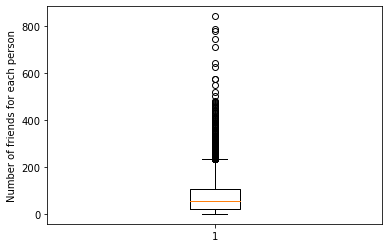

In [9]:
plt.boxplot(degree_dist)
plt.ylabel('Number of friends for each person')
plt.show()

In [10]:
print(np.median(degree_dist))
print(np.mean(degree_dist))

54.0
75.32529757420521


In [11]:
print('There are',sum(np.array(degree_dist)==0),'person having zero friend. There are' ,sum(np.array(degree_dist)==1),'having 1 friend, which represents' , sum(np.array(degree_dist)==1)*100/len(degree_dist) ,'% of the total number of persons',
                                 )

There are 0 person having zero friend. There are 205 having 1 friend, which represents 3.0887449148711767 % of the total number of persons


In [12]:
from collections import Counter
dict_friends = dict(g.degree())
d = Counter(dict_friends)
degree = np.array(list(d.values()))

In [13]:
print('Number of persons having less than 10 friends is',np.sum(degree<10))

Number of persons having less than 10 friends is 891


MODEL GENERATION

In [14]:
#generate negative samples
missing=[]
while len(missing)< len(edges):
    a=random.randint(1,4031)
    b=random.randint(1,4031)
    e=edges.get((a,b),0)
    if e==0 and a!=b:
        try:
            if(nx.shortest_path_length(g,a,b)>2):
                missing.append((a,b))
            else:
                continue
        except:
            missing.append((a,b))

In [15]:
#define the complete set
facebook=[]
target=[]
for a,b in dataset:
    facebook.append((int(a),int(b)))
    target.append(1)
for a,b in missing:
    facebook.append((a,b))
    target.append(0)

In [16]:
temp=list(zip(facebook,target))
random.shuffle(temp)
facebook,target=zip(*temp)
X_train, X_test, y_train, y_test=train_test_split(facebook,target,train_size=0.2)

In [17]:
#how many connections needed for two people to be friends
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if g.has_edge(a,b):
            g.remove_edge(a,b)
            p= nx.shortest_path_length(g,source=a,target=b)
            g.add_edge(a,b)
        else:
            p= nx.shortest_path_length(g,source=a,target=b)
        return p
    except:
        return -1

In [18]:
#Compute Adar Index
preds = nx.adamic_adar_index(g)
x={}
for u,v,val in preds:
    x[(u,v)]=val

In [19]:
#Compute Jaccard similarity
preds_jaccard=nx.jaccard_coefficient(g)
x_jaccard={}
for u,v,val in preds_jaccard:
    x_jaccard[(u,v)]=val

In [20]:
#Compute common neighbors
def CommonNeighbors(u, v):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors))

In [21]:
#Compute harmonic centrality for the whole graph
harmonic_centrality = nx.harmonic_centrality(g)

In [22]:
# compute betweeness_centrality
betweenness_centrality = nx.betweenness_centrality(g)

In [23]:
# compute eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(g,max_iter=1000)

In [31]:
#training feature generation
adar=[]
shortest_dist=[]
jaccard=[]
betweeness_a=[]
betweeness_b=[]
eigenvector_a=[]
eigenvector_b=[]
harmonic_a=[]
harmonic_b=[]
common_neig=[]
for a,b in X_train:
    adar.append(x.get((a,b),0))
    shortest_dist.append(compute_shortest_path_length(a,b))
    common_neig.append(CommonNeighbors(a,b))
    jaccard.append(x_jaccard.get((a,b),0))
    eigenvector_a.append(eigenvector_centrality.get(a,0))
    eigenvector_b.append(eigenvector_centrality.get(b,0))
    betweeness_a.append(betweenness_centrality.get(a,0))
    betweeness_b.append(betweenness_centrality.get(b,0))
    harmonic_a.append(harmonic_centrality.get(a,0))
    harmonic_b.append(harmonic_centrality.get(b,0))

In [32]:
#Training set
training=np.array([adar,shortest_dist,common_neig, jaccard,betweeness_a,betweeness_b, harmonic_a,harmonic_b,eigenvector_a,eigenvector_b]).T



In [33]:
#Classifier
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(training, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [37]:
#testing feature generation
adar_test=[]
shortest_dist_test=[]
common_neig_test=[]
jaccard_test=[]
eigenvector_test_a=[]
eigenvector_test_b =[]
betweeness_test_a=[]
betweeness_test_b=[]
harmonic_test_a=[]
harmonic_test_b=[]
for a,b in X_test:
    adar_test.append(x.get((a,b),0))
    shortest_dist_test.append(compute_shortest_path_length(a,b))
    common_neig_test.append(CommonNeighbors(a,b))
    jaccard_test.append(x_jaccard.get((a,b),0))
    eigenvector_test_a.append(eigenvector_centrality.get(a,0))
    eigenvector_test_b.append(eigenvector_centrality.get(b,0))
    betweeness_test_a.append(betweenness_centrality.get(a,0))
    betweeness_test_b.append(betweenness_centrality.get(b,0))
    harmonic_test_a.append(harmonic_centrality.get(a,0))
    harmonic_test_b.append(harmonic_centrality.get(b,0))

In [38]:
# Testing set
testing=np.array([adar_test,shortest_dist_test,common_neig_test,jaccard_test,betweeness_test_a,betweeness_test_b, harmonic_test_a,harmonic_test_b, eigenvector_test_a,eigenvector_test_b]).T


In [39]:
# Score with XGBClassifier
from sklearn.metrics import accuracy_score
y_pred_xgb=classifier_xgb.predict(testing)
accuracy_score(y_pred_xgb,y_test)

0.9944592797063618

In [40]:
#With linear regression
from sklearn import svm
classifier_svm001 = svm.LinearSVC(C=0.01)
classifier_svm001.fit(training, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [41]:
# Score  with LinearSVC C=0.01
from sklearn.metrics import accuracy_score
y_pred_svm001=classifier_svm001.predict(testing)
accuracy_score(y_pred_svm001,y_test)

0.9825552321801834

In [42]:
#With random forest
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier()
classifier_rf.fit(training, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
# Score with Random forest
from sklearn.metrics import accuracy_score
y_pred_rf=classifier_rf.predict(testing)
accuracy_score(y_pred_rf,y_test)

0.9944917839319112

In [44]:
#With linear regression
from sklearn import svm
classifier_svm = svm.LinearSVC()
classifier_svm.fit(training, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [45]:
# Score with LinearSVC
from sklearn.metrics import accuracy_score
y_pred_svm=classifier_svm.predict(testing)
accuracy_score(y_pred_svm,y_test)

0.9795723444047726

In [46]:
#With linear Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier
classifier_pac = PassiveAggressiveClassifier()
classifier_pac.fit(training, y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

In [47]:
# Score Vaibhav with Passive Aggressive Classifier
from sklearn.metrics import accuracy_score
y_pred_pac=classifier_pac.predict(testing)
accuracy_score(y_pred_pac,y_test)

0.9481282566733675